# ENSEMBLE MODEL

**Analyze data white_wine.csv**  

Apply Voting Classifier  
* target : quality (quality >6 → Y = 1)
* features : density alcohol
* Validate the model using precision, recall and f1 score in 20% testing data

Apply soft voting classifier method, using these following method:  
* logistic regression 
* decision tree : max depth 5
* knn : nearest neighbor 3

Apply soft voting classifier method, using these following method  
* 3rd degree polynomial features + logistic regression 
* decision tree : max depth 5
* standard scaler + knn : nearest neighbor 3


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier # UNTUK VOTING
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, f1_score, recall_score, precision_score


In [2]:
wine = pd.read_csv('white_wine.csv')
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
515,6.1,0.31,0.26,2.2,0.051,28.0,167.0,0.9926,3.37,0.47,10.4,6.0
516,6.8,0.18,0.37,1.6,0.055,47.0,154.0,0.9934,3.08,0.45,9.1,5.0
517,7.4,0.15,0.42,1.7,0.045,49.0,154.0,0.9920,3.00,0.60,10.4,6.0
518,5.9,0.13,0.28,1.9,0.050,20.0,78.0,0.9918,3.43,0.64,10.8,6.0


In [3]:
wine['alcohol'].fillna(wine['alcohol'].mean(),inplace=True)
wine['label'] =np.where(wine['quality']>6,1,0)

In [4]:
X = wine[['density','alcohol']]
y = wine['label']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size=0.2, random_state = 2020)

## Kita coba dengan soft voting

# 1. Modeling Base

# Standalone Model

In [7]:
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth=5)
knn = KNeighborsClassifier(n_neighbors=3)

In [8]:
# for clfs, clf_name in zip([lr,dt,knn],['Logistic Regression','Decision Tree','KNN']):
#   clfs.fit(X_train, y_train)
#   y_pred = clfs.predict(X_test)
#   print(clf_name+":")
#   print(classification_report(y_test,y_pred))


In [9]:
models = {
    'logistic regresion': LogisticRegression(),
    'decision tree': DecisionTreeClassifier(max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=3)
}


for i in models:
    models[i].fit(X_train, y_train)
    y_pred = models[i].predict(X_test)
    print(i, '\n', classification_report(y_test, y_pred))

logistic regresion 
               precision    recall  f1-score   support

           0       0.88      0.96      0.92        84
           1       0.75      0.45      0.56        20

    accuracy                           0.87       104
   macro avg       0.82      0.71      0.74       104
weighted avg       0.86      0.87      0.85       104

decision tree 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        84
           1       1.00      0.90      0.95        20

    accuracy                           0.98       104
   macro avg       0.99      0.95      0.97       104
weighted avg       0.98      0.98      0.98       104

KNN 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94        84
           1       0.75      0.75      0.75        20

    accuracy                           0.90       104
   macro avg       0.85      0.85      0.85       104
weighted avg       0.90      0.

In [11]:
models = {
    'logistic regresion': LogisticRegression(),
    'decision tree': DecisionTreeClassifier(max_depth=5),
    'KNN': KNeighborsClassifier(n_neighbors=3)
}
score=[]

for i in models:
    models[i].fit(X_train, y_train)
    y_pred = models[i].predict(X_test)
    score.append([precision_score(y_test,y_pred), recall_score(y_test,y_pred), f1_score(y_test,y_pred)])

df_score = pd.DataFrame(score, columns=['Precision','Recall','f1'], index= models.keys())

df_score

,Precision,Recall,f1
logistic regresion,0.75,0.45,0.562500
decision tree,1.00,0.90,0.947368
KNN,0.75,0.75,0.750000


# Voting Classifier

In [12]:
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth=5)
knn = KNeighborsClassifier(n_neighbors=3)

vc = VotingClassifier([('clf1',lr),('clf2',dt),('clf',knn)], voting='soft')

In [13]:
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('clf1', LogisticRegression()),
                             ('clf2', DecisionTreeClassifier(max_depth=5)),
                             ('clf', KNeighborsClassifier(n_neighbors=3))],
                 voting='soft')

In [14]:
y_pred = vc.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        84
           1       1.00      0.80      0.89        20

    accuracy                           0.96       104
   macro avg       0.98      0.90      0.93       104
weighted avg       0.96      0.96      0.96       104



In [17]:
df_score

,Precision,Recall,f1
logistic regresion,0.75,0.45,0.562500
decision tree,1.00,0.90,0.947368
KNN,0.75,0.75,0.750000


# 2. Modeling Improvement

# Standalone

# Voting Classifier

In [16]:
lr = LogisticRegression()
lr_poly = PolynomialFeatures(degree = 3, interaction_only=False,include_bias=False)
pipe_lr = Pipeline([('preprocess',lr_poly),('clf',lr)])

dt = DecisionTreeClassifier(max_depth = 5)

knn = KNeighborsClassifier(n_neighbors = 3)
pipe_knn = Pipeline([('preprocess',StandardScaler()),('clf',knn)])

vc = VotingClassifier([('clf1',pipe_lr),('clf2',dt),('clf3',pipe_knn)], voting = 'soft')


# RANDOM FOREST

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
bankloan = pd.read_csv('bankloan.csv')
bankloan.head(3)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1
1,27,1,10,6,31,17.3,1.362202,4.000798,0
2,40,1,15,14,55,5.5,0.856075,2.168925,0


In [34]:
fitur = ['age','employ', 'debtinc', 'creddebt', 'othdebt']
target = 'default'

X = bankloan[fitur]
y = bankloan[target]

In [35]:
bankloan['default'].value_counts()/bankloan.shape[0]*100

0    73.857143
1    26.142857
Name: default, dtype: float64

## Data Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    stratify = y,
    test_size = 0.2, 
    random_state = 2020)

## Modeling

In [37]:
rf = RandomForestClassifier(n_estimators=20, max_features=4, max_depth=3)

In [38]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=4, n_estimators=20)

In [39]:
y_pred = rf.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       103
           1       0.70      0.43      0.53        37

    accuracy                           0.80       140
   macro avg       0.76      0.68      0.70       140
weighted avg       0.79      0.80      0.78       140



# Membandingkan Decision Tree dan Random Forest

In [42]:
wine = pd.read_csv('white_wine.csv')


In [43]:
wine['alcohol'].fillna(wine['alcohol'].mean(),inplace=True)
wine['label'] =np.where(wine['quality']>6,1,0)

X = wine[['density','alcohol']]
y = wine['label']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size=0.2, random_state = 2020)

## DecisionTree

In [46]:
dt = DecisionTreeClassifier(max_depth=3)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        84
           1       1.00      0.75      0.86        20

    accuracy                           0.95       104
   macro avg       0.97      0.88      0.91       104
weighted avg       0.95      0.95      0.95       104



In [ ]:
# ,n_estimators=20, max_features=4

## Random Forest

In [48]:
rf = RandomForestClassifier(max_depth=3)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        84
           1       1.00      0.80      0.89        20

    accuracy                           0.96       104
   macro avg       0.98      0.90      0.93       104
weighted avg       0.96      0.96      0.96       104



# Decision Boundaries

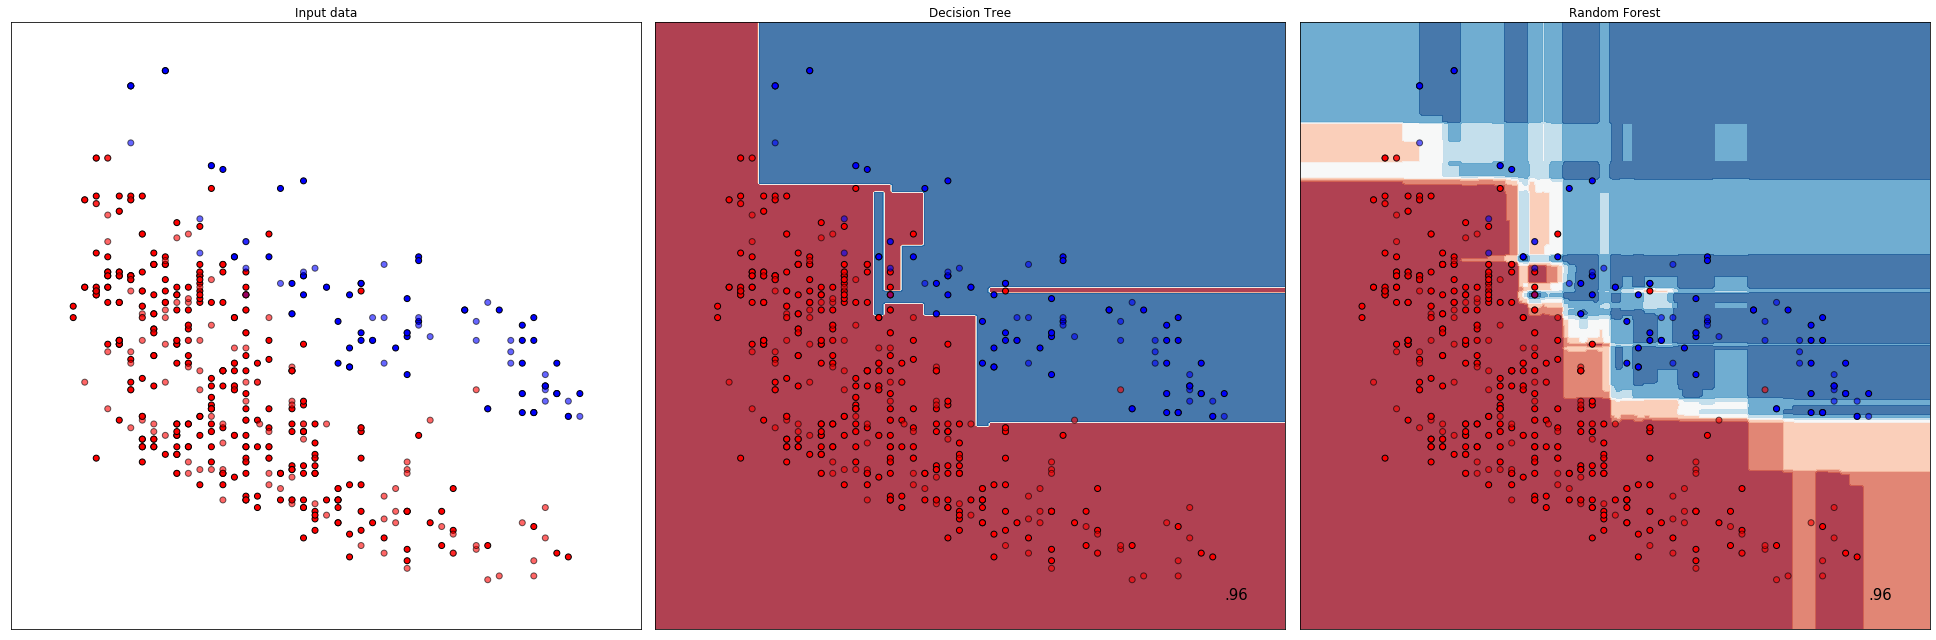

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

h = .02  # step size in the mesh

names = ["Decision Tree", "Random Forest"]

classifiers = [
    DecisionTreeClassifier(), # you can add more model
    RandomForestClassifier(n_estimators=20)]

X = wine[['alcohol','density']]
y = wine['label']
linearly_separable = (X, y)

datasets = [
            linearly_separable # you can add more dataset
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()


** Titanic.csv**

* Explore: Bagaimana setiap feature berhubungan dengan apakah seseorang survive/ alive.
* Splitting: 80-20, stratify: y, random state 2020
* Preprocessing: 
>* drop deck
>* Isi missing value menggunakan simple imputer 
>* onehot encoding: sex, alone  
>* ordinal encoding: class  
>* binary encoding: embarked town  

* Model selection:
>* evaluation metric yang dipakai: F1_score
>* Logreg, KNN, DecisionTreeClassifier, RandomForestClassifier
>* Hyperparameter tuning 2 model yang menurut kalian terbaik
>* Buat summary untuk hasil evaluasi, dan kesimpulan mana model yang terbaik untuk titanic.csv

Kalau bisa, gunakan pipeline ketika diperlukan untuk menghindari data leaking.

email hasil modelling kalian ke Brigita.gems@gmail.com dengan subject: titanic
